
# Classification in Machine Learning — Session 5

**Goal:** Learn what classification is, how common algorithms work (Logistic Regression, Decision Trees), how to extend to multiclass (OvR & OvO), and how to evaluate models with practical, hands-on Python examples.

**You will learn:**
- The difference between **classification** and **regression**.
- How **Logistic Regression** models probabilities and builds decision boundaries.
- How **Decision Trees** split data using **Gini** or **Entropy**.
- How to handle **multiclass** problems using **One-vs-Rest (OvR)** and **One-vs-One (OvO)**.
- How to evaluate classifiers using **confusion matrix**, **precision**, **recall**, **F1-score**, **ROC**, and **Precision–Recall** curves.
- How to use **cross-validation** and **hyperparameter tuning**.



## 0. Setup

We'll use standard scientific Python libraries. This notebook avoids seaborn per your environment requirements and uses only **matplotlib** for plots.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

np.random.seed(42)
print("Libraries imported.")

Libraries imported.



## 1. What is Classification?

**Classification** is a supervised learning task where a model learns to assign **discrete labels** to inputs. For example:

- Email filtering: _Spam_ vs. _Not Spam_
- Medical diagnosis: _Benign_ vs. _Malignant_
- Image recognition: _Cat_, _Dog_, _Bird_
- Fraud detection: _Legitimate_ vs. _Fraudulent_

**Regression** predicts **continuous** values (e.g., house price), while **classification** predicts **discrete** categories (e.g., spam/not spam).

We'll start with a **binary** example, then extend to **multiclass**.



## 2. Binary Classification with Logistic Regression

We'll use the classic **Iris** dataset but restrict it to **two classes** for a binary example.


In [3]:
# Load Iris and reduce to binary (classes 0 and 1)
iris = load_iris()
X_all = iris.data
y_all = iris.target

mask = y_all != 2  # keep only setosa (0) and versicolor (1)
X = X_all[mask]
y = y_all[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Classes:", np.unique(y))


Train shape: (75, 4)  Test shape: (25, 4)
Classes: [0 1]



### 2.1 Logistic Regression — Intuition & Math

Despite its name, **Logistic Regression** is a **classification** algorithm. It models the probability that an input belongs to the positive class:

\begin{align}
\hat{y} &= \sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{where } z = \mathbf{w}^\top \mathbf{x} + b\\
\text{Decision rule: } & \hat{y} > 0.5 \Rightarrow \text{Class 1, else Class 0}
\end{align}

The model is trained by minimizing **log-loss** using gradient-based optimization.



### 2.2 Fit & Evaluate Logistic Regression
We'll standardize features (good practice for linear models), then fit and evaluate.


In [ ]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])
log_reg_pipeline.fit(X_train, y_train)

y_pred = log_reg_pipeline.predict(X_test)
y_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



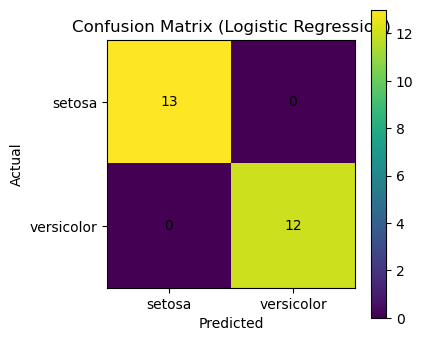

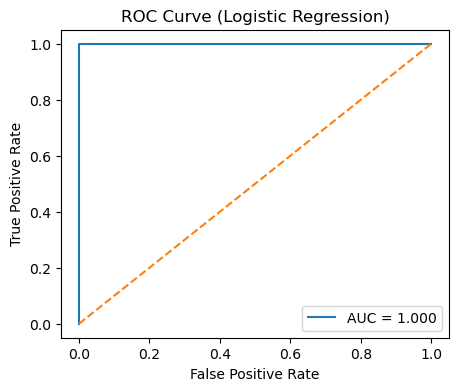

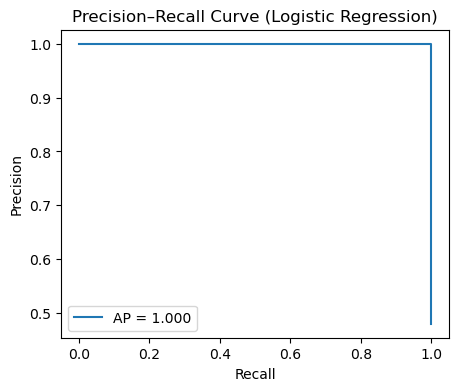

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names[:2]))

# Confusion matrix plot using matplotlib only
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)
ax.set_title("Confusion Matrix (Logistic Regression)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(iris.target_names[:2])
ax.set_yticklabels(iris.target_names[:2])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


### 2.3 Visualizing the Decision Boundary (2D via PCA)

To **visualize** decision boundaries, we project features to **2D** using PCA and plot the learned boundary.


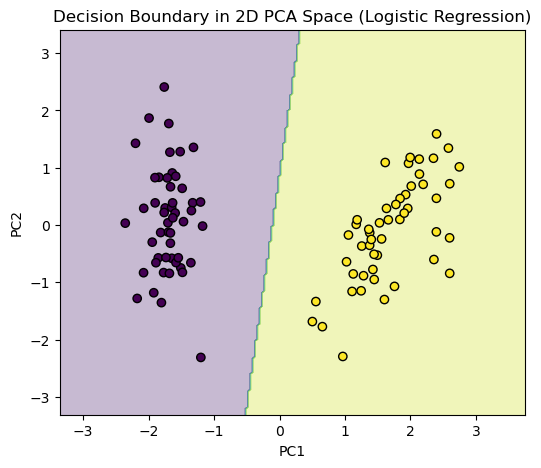

In [5]:
# Reduce to 2D for visualization
pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),
    ("clf", LogisticRegression())
])
pca_pipeline.fit(X_train, y_train)

# Meshgrid over transformed space
X_vis = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2))]).fit_transform(X)
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_2d = np.c_[xx.ravel(), yy.ravel()]

# Predict on grid by inverting PCA pipeline parts
# We'll construct a helper pipeline for prediction in the original space:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA(n_components=2).fit(X_train_scaled)

# To get predictions from 2D PCA space, we approximate by training a classifier on the PCA-transformed space directly.
clf2d = LogisticRegression().fit(pca.transform(scaler.transform(X_train)), y_train)
Z = clf2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolor="k")
plt.title("Decision Boundary in 2D PCA Space (Logistic Regression)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



## 3. Decision Trees — Learning via Questions

Decision Trees learn **if/else** questions about features. Each split aims to **reduce impurity**.

- **Gini Impurity:** $ G = 1 - \sum_{i=1}^C p_i^2 $
- **Entropy:** $ H = -\sum_{i=1}^C p_i \log_2 p_i $
- **Information Gain:** reduction in impurity after a split.



### 3.1 Train & Visualize a Decision Tree (Multiclass Iris)


In [20]:
# Use full Iris (3 classes)
X3 = X_all
y3 = y_all
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=42, stratify=y3)

tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
tree_clf.fit(X3_train, y3_train)
y3_pred = tree_clf.predict(X3_test)

Decision Tree Accuracy (Iris multiclass): 0.8947368421052632

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38



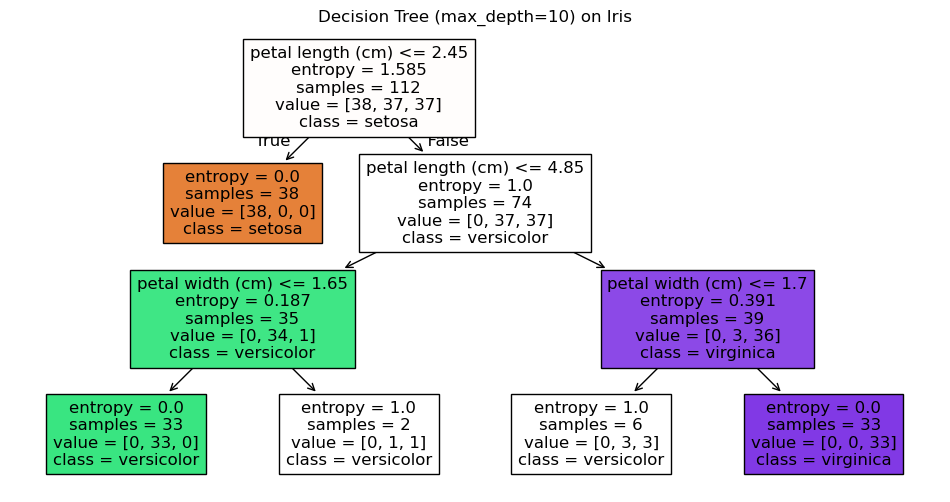

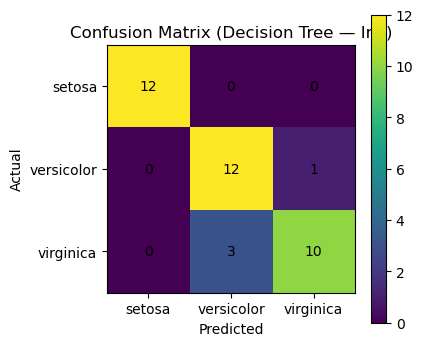

In [21]:
print("Decision Tree Accuracy (Iris multiclass):", accuracy_score(y3_test, y3_pred))
print("\nClassification Report:\n", classification_report(y3_test, y3_pred, target_names=iris.target_names))

plt.figure(figsize=(12,6))
plot_tree(tree_clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.title("Decision Tree (max_depth=10) on Iris")
plt.show()

# Confusion matrix
cm3 = confusion_matrix(y3_test, y3_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm3)
ax.set_title("Confusion Matrix (Decision Tree — Iris)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels(iris.target_names)
ax.set_yticklabels(iris.target_names)
for i in range(cm3.shape[0]):
    for j in range(cm3.shape[1]):
        ax.text(j, i, cm3[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax)
plt.show()


## 4. Handling Multiple Classes: One-vs-Rest (OvR) & One-vs-One (OvO)

When there are more than two classes, we can extend binary classifiers:

- **OvR (One-vs-Rest):** Train one classifier per class vs. all others (efficient when classes are many).
- **OvO (One-vs-One):** Train one classifier per pair of classes (more models, but each is simpler).


In [7]:

# Use Iris multiclass with Logistic Regression base estimator
ova = OneVsRestClassifier(LogisticRegression())
ovo = OneVsOneClassifier(LogisticRegression())

ova.fit(X3_train, y3_train)
ovo.fit(X3_train, y3_train)

acc_ova = accuracy_score(y3_test, ova.predict(X3_test))
acc_ovo = accuracy_score(y3_test, ovo.predict(X3_test))

print(f"OvR Accuracy: {acc_ova:.3f}")
print(f"OvO Accuracy: {acc_ovo:.3f}")


OvR Accuracy: 0.895
OvO Accuracy: 0.921



## 5. Evaluation Metrics

For **binary** classification, we commonly examine:
- **Accuracy** = (TP + TN) / (TP + FP + TN + FN)
- **Precision** = TP / (TP + FP) — how many predicted positives are correct.
- **Recall (Sensitivity)** = TP / (TP + FN) — how many actual positives we found.
- **F1-score** — harmonic mean of precision and recall.
- **ROC Curve** and **AUC**.
- **Precision–Recall Curve** and **Average Precision (AP)** — especially useful with **imbalanced** data.

For **multiclass**, use macro-averaged or weighted metrics (e.g., macro F1).



## 6. Practical Example: Medical Diagnosis (Breast Cancer Dataset)

We'll use scikit-learn's **Breast Cancer Wisconsin** dataset (binary). We'll build a logistic regression classifier and analyze performance.


Accuracy (Breast Cancer): 0.986013986013986

Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



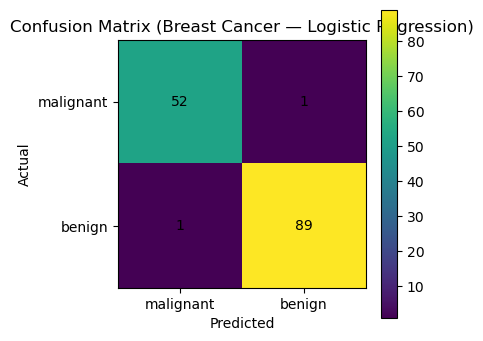

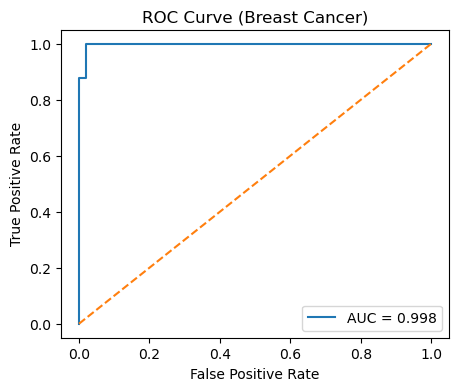

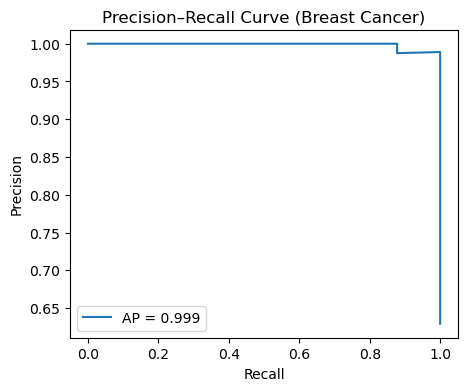

In [8]:

bc = load_breast_cancer()
Xb, yb = bc.data, bc.target
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.25, random_state=42, stratify=yb)

pipe_bc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
pipe_bc.fit(Xb_train, yb_train)

yb_pred = pipe_bc.predict(Xb_test)
yb_proba = pipe_bc.predict_proba(Xb_test)[:,1]

print("Accuracy (Breast Cancer):", accuracy_score(yb_test, yb_pred))
print("\nClassification Report:\n", classification_report(yb_test, yb_pred, target_names=bc.target_names))

# Confusion matrix
cmb = confusion_matrix(yb_test, yb_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cmb)
ax.set_title("Confusion Matrix (Breast Cancer — Logistic Regression)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(bc.target_names)
ax.set_yticklabels(bc.target_names)
for i in range(cmb.shape[0]):
    for j in range(cmb.shape[1]):
        ax.text(j, i, cmb[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax)
plt.show()

# ROC
fpr_b, tpr_b, _ = roc_curve(yb_test, yb_proba)
roc_auc_b = auc(fpr_b, tpr_b)
plt.figure(figsize=(5,4))
plt.plot(fpr_b, tpr_b, label=f"AUC = {roc_auc_b:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Breast Cancer)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PR
prec_b, rec_b, _ = precision_recall_curve(yb_test, yb_proba)
ap_b = average_precision_score(yb_test, yb_proba)
plt.figure(figsize=(5,4))
plt.plot(rec_b, prec_b, label=f"AP = {ap_b:.3f}")
plt.title("Precision–Recall Curve (Breast Cancer)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()



## 7. Cross-Validation & Hyperparameter Tuning

We'll use **cross-validation** to estimate performance and **GridSearchCV** to tune hyperparameters for a Decision Tree.


In [9]:

# Cross-validation with Logistic Regression (binary Iris subset)
cv_scores = cross_val_score(log_reg_pipeline, X, y, cv=5, scoring="accuracy")
print("5-Fold CV Accuracy (Iris binary, Logistic Regression):")
print("Scores:", np.round(cv_scores, 3), "  Mean:", np.round(cv_scores.mean(), 3))

# Grid search on Decision Tree (Iris multiclass)
param_grid = {
    "max_depth": [2, 3, 4, 5, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X3_train, y3_train)
print("\nBest Params:", grid.best_params_)
print("Best CV Score:", np.round(grid.best_score_, 3))

best_tree = grid.best_estimator_
print("Test Accuracy of best tree:", accuracy_score(y3_test, best_tree.predict(X3_test)))


5-Fold CV Accuracy (Iris binary, Logistic Regression):
Scores: [1. 1. 1. 1. 1.]   Mean: 1.0

Best Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Best CV Score: 0.938
Test Accuracy of best tree: 0.8947368421052632
